In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [6]:
from preprocess import Preprocess
from training import Server

p = Preprocess()
p.main_run(gan_sim=True)

# we tried the training process on 4 Tesla V100 cards.
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3' 

# t = Server()
# t.train()
# props,y_truth = t.predict()


data/crossval_indices.pkl exists already.


In [7]:
!mv data/tordata300.h5 data/tordata300_gan_simplex.h5


In [4]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from training import Server
from tqdm.notebook import tqdm

def print_pred(h5_path,gan_sim=False):
    t = Server(pred_only=True, h5_path=h5_path, gan_sim=gan_sim)
    props,y_truth = t.predict()
    plot_hist(props, y_truth)
    plot_roc(props, y_truth)
    plt_confusion(props, y_truth)
    
def plot_hist(props, y_truth):
    print('y_truth: ', y_truth[30:54])
    print('y_pred: ', (tf.sigmoid(props) >= 0.5).numpy().astype(float)[30:54])
    plt.figure()
    fig,axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].hist(y_truth)
    axs[1].hist((tf.sigmoid(props) >= 0.5).numpy().astype(float))
    axs[0].set_title('y_truth')
    axs[1].set_title('y_pred')
    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()
    return

def plot_roc(props, y_truth, text=None, t_place=None, figsize=None, t_size=15):
    '''
    text: str
    t_place: tuple/list
    '''
    scores = tf.sigmoid(props).numpy().astype(float)
    fpr, tpr, thresholds = metrics.roc_curve(y_truth, scores, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, color='darkorange',
             label=f'ROC curve (auc = {auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.tick_params(labelsize=t_size-1)
    plt.xlabel('False Positive Rate', size=t_size)
    plt.ylabel('True Positive Rate', size=t_size)
    plt.title('Receiver Operating Characteristic Curve', size=t_size+1)
    if t_place is not None:
        plt.text(*t_place,text, size=t_size)
    plt.legend(fontsize=t_size)
    plt.show()
    return

def plt_confusion(props, y_truth):
    y_pred = (tf.sigmoid(props) >= 0.5).numpy().astype(float)
    plt.figure()
    sns.heatmap(confusion_matrix(y_truth, y_pred),annot=True)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Ground truth')
    plt.show()
    return

def plt_roc_on_corr(h5_path, gan_sim=False):
    with h5py.File(h5_path,'r') as f:
        n = len(f['indices']['test'])
        corrs = np.zeros((n,4))
        y_truth = []
        for i in tqdm(range(n),desc='Calculate Pearson Correlation Coefficients'):
            index = f['indices']['test'][i]
            if gan_sim:
                x = f['data']['x_gan'][index]
            else:
                x = f['data']['x'][index]
            y = f['data']['y'][index]
            y_truth.append(y)
            for j in range(4):
                corrs[i,j] = abs(np.corrcoef(x[2*j:2*j+2])[0,1])
    text = ['time: here  <-\n         there ->',
            'time: there <-\n         here  ->',
            'size: here  <-\n        there ->',
            'size: there <-\n        here   ->']
    for i in range(4):
        plot_roc(corrs[:,i], y_truth, text=text[i], t_place=[0.65,0.2])

Original Data


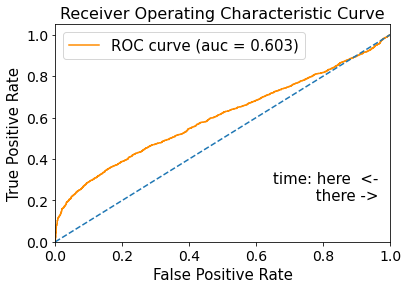

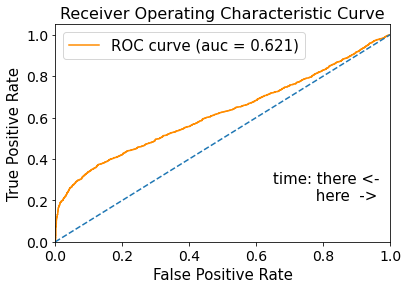

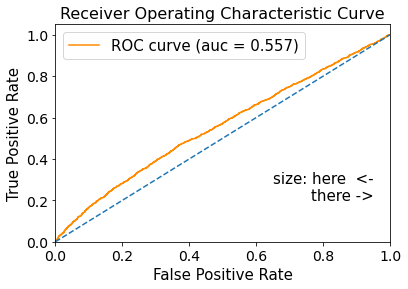

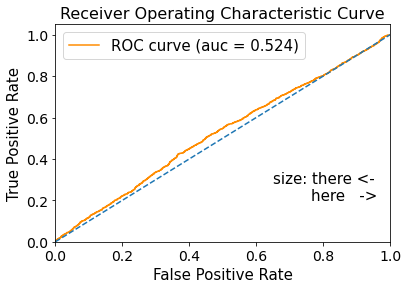

GAN Sim Data


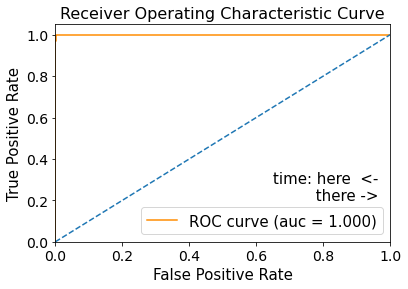

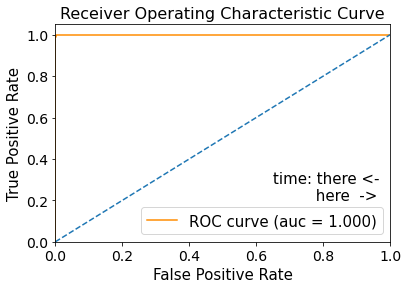

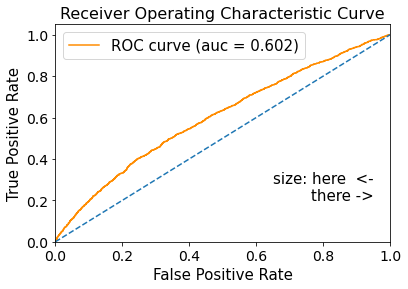

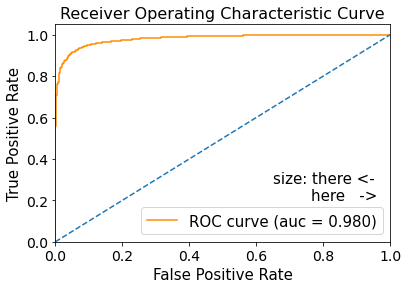

In [5]:
print('Original Data')
plt_roc_on_corr('data/tordata300_gan_duplex.h5')
print('GAN Sim Data')
plt_roc_on_corr('data/tordata300_gan_duplex.h5', gan_sim=True)

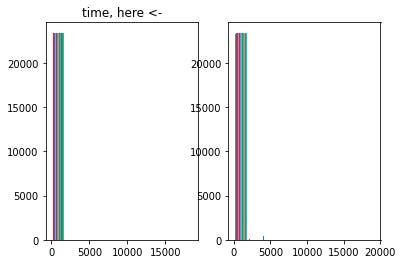

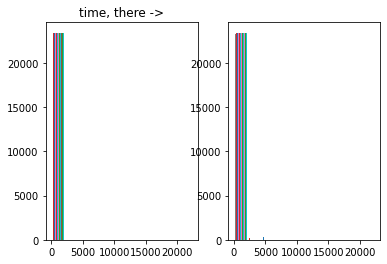

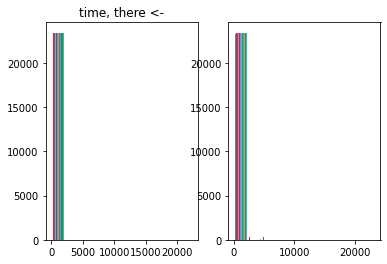

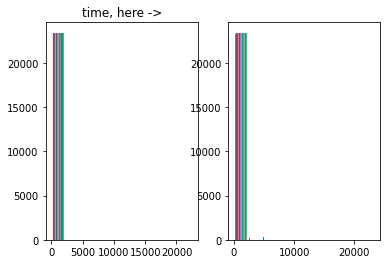

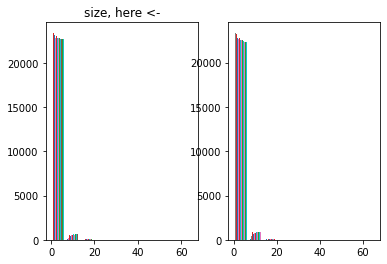

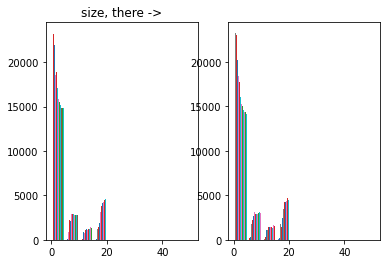

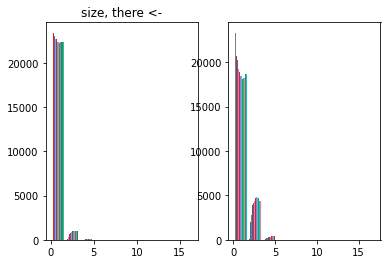

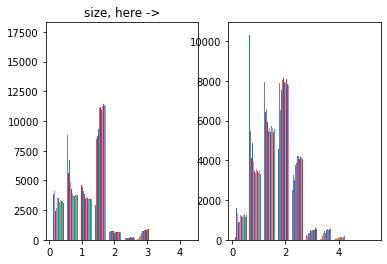

In [31]:
with h5py.File('data/tordata300_gan_duplex.h5','r') as f:
    label = ['time, here <-',
             'time, there ->',
            'time, there <-',
            'time, here ->',
            'size, here <-',
            'size, there ->',
            'size, there <-',
            'size, here ->']
    for i in range(8):
        _,ax = plt.subplots(1,2)
        ax[0].hist(f['data']['x'][:,i,:])
        ax[1].hist(f['data']['x_gan'][:,i,:])
        ax[0].set_title(label[i])

Original Data


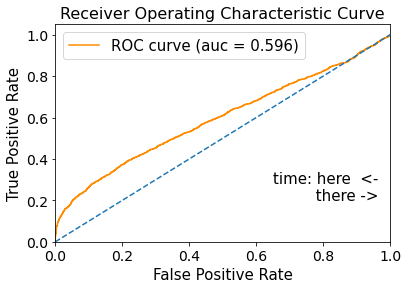

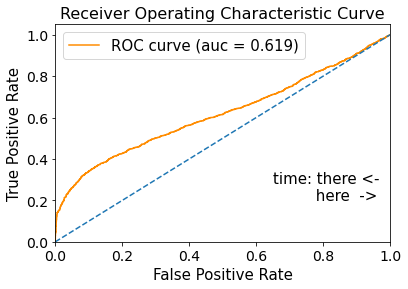

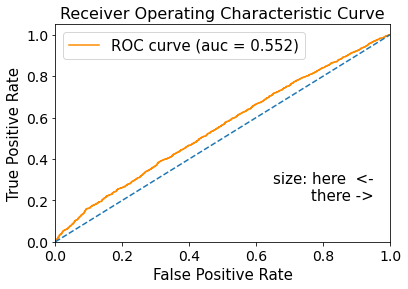

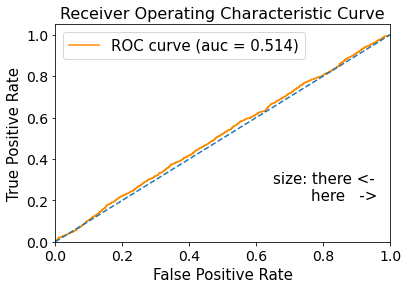

GAN Sim Data


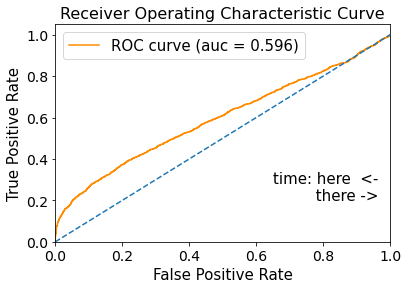

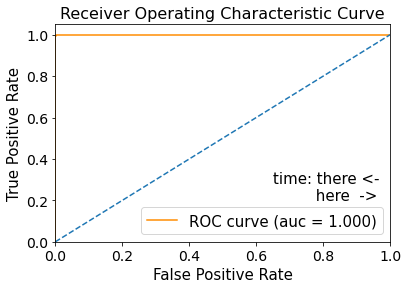

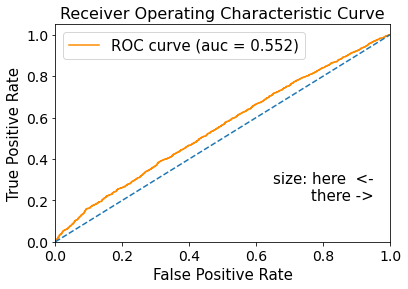

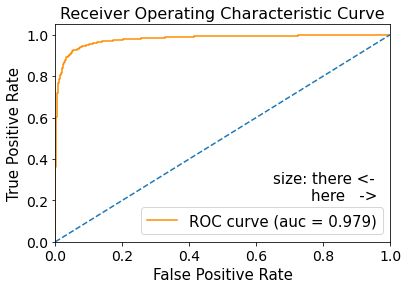

In [8]:
print('Original Data')
plt_roc_on_corr('data/tordata300_gan_simplex.h5')
print('GAN Sim Data')
plt_roc_on_corr('data/tordata300_gan_simplex.h5', gan_sim=True)

We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 0.321, accuracy = 0.881
y_truth:  [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
y_pred:  [0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


<Figure size 432x288 with 0 Axes>

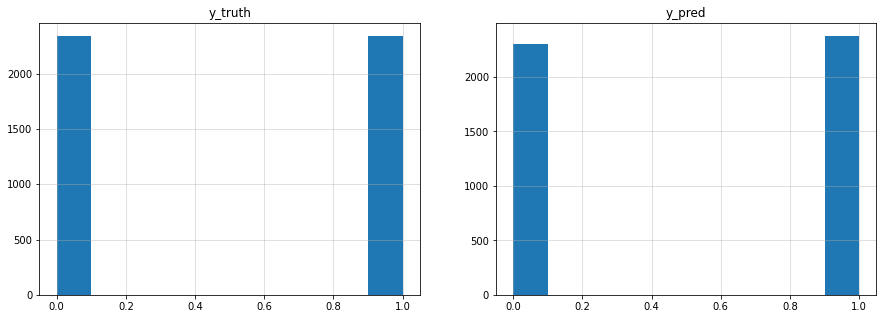

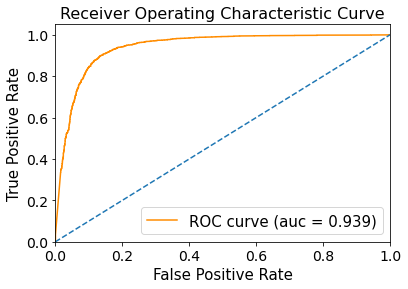

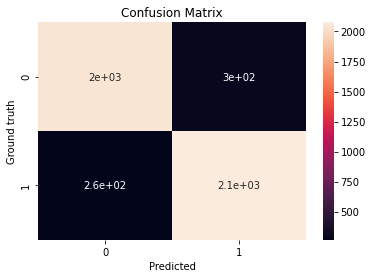

In [9]:
print_pred('data/tordata300.h5.bak')

We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 0.288, accuracy = 0.903
y_truth:  [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
y_pred:  [1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


<Figure size 432x288 with 0 Axes>

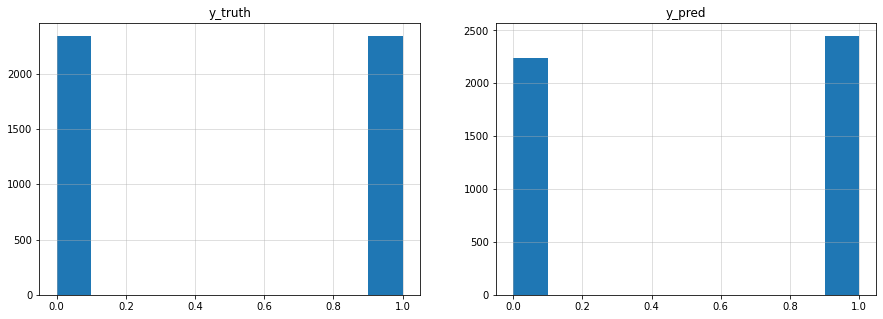

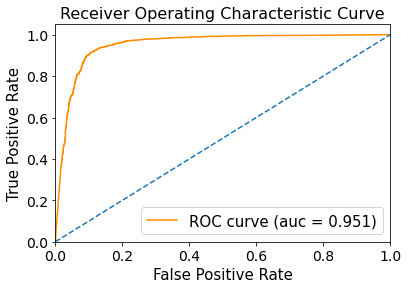

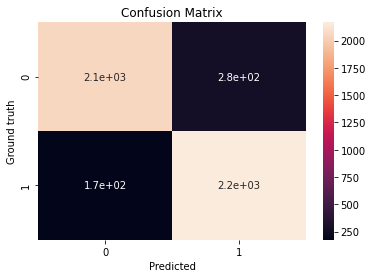

In [5]:
print_pred('data/tordata300_gan_duplex.h5')

We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 1.155, accuracy = 0.68
y_truth:  [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
y_pred:  [1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<Figure size 432x288 with 0 Axes>

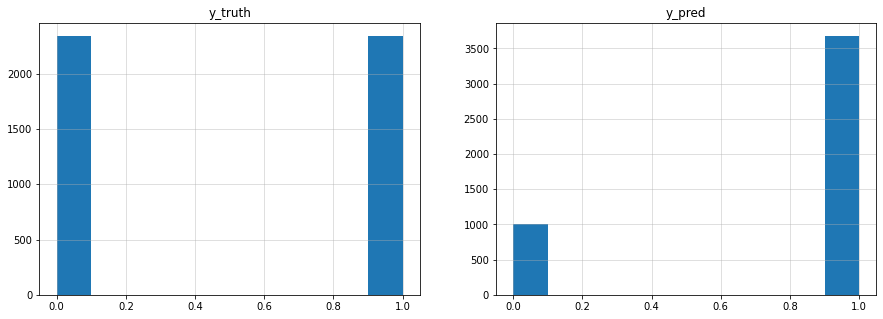

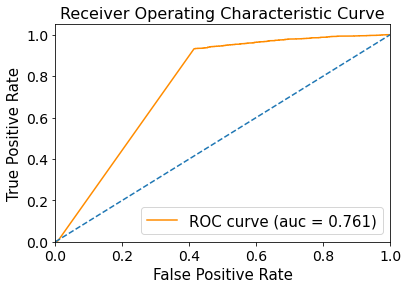

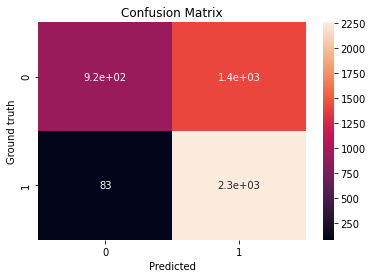

In [6]:
print_pred('data/tordata300_gan_duplex.h5',gan_sim=True)

We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 3.526, accuracy = 0.49
y_truth:  [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
y_pred:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

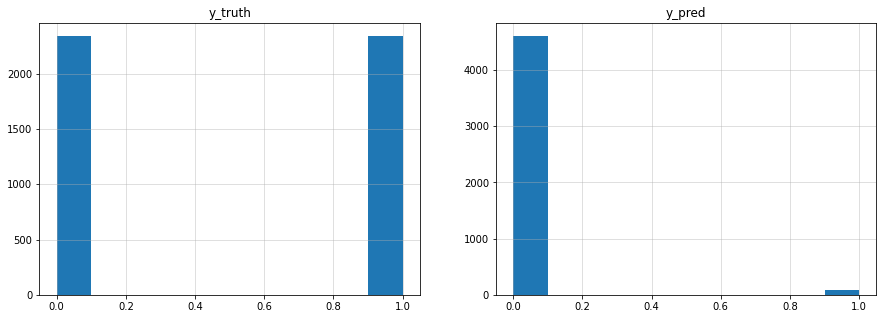

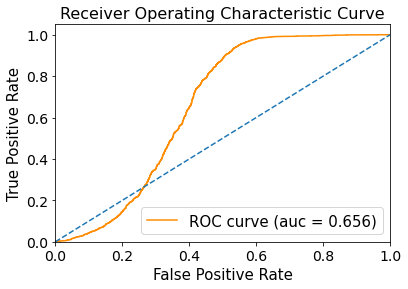

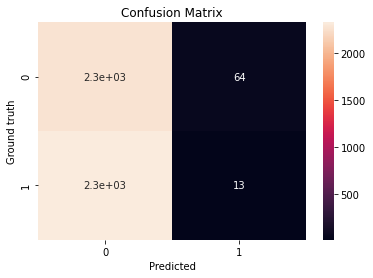

In [7]:
print_pred('data/tordata300_gan_simplex.h5',gan_sim=True)

fake x, fake y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 1.645, accuracy = 0.521
y_truth:  [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]


<Figure size 432x288 with 0 Axes>

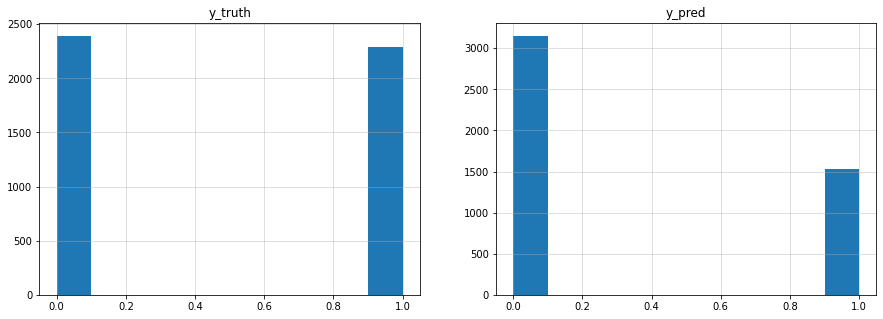

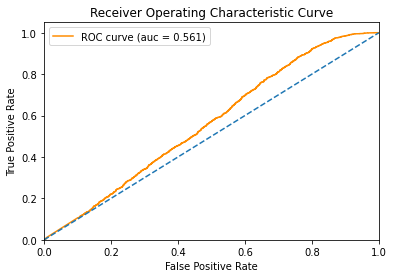

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 1.837, accuracy = 0.737
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]


<Figure size 432x288 with 0 Axes>

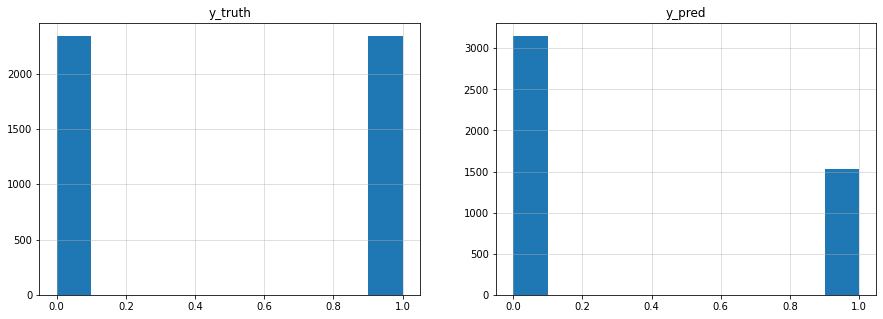

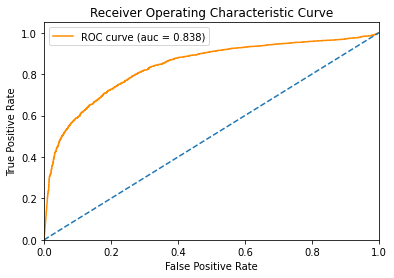

In [5]:
print('real x, real y')
print_pred('data/pt_simple_1gd/realxy.h5')
print('fake x, fake y')
print_pred('data/pt_simple_1gd/fakexy.h5')
print('fake x, real y')
print_pred('data/pt_simple_1gd/fakex_realy.h5')

fake x, fake y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 1.777, accuracy = 0.505
y_truth:  [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]


<Figure size 432x288 with 0 Axes>

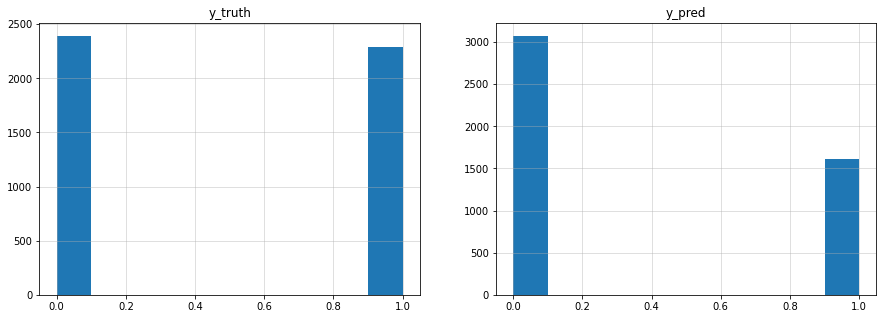

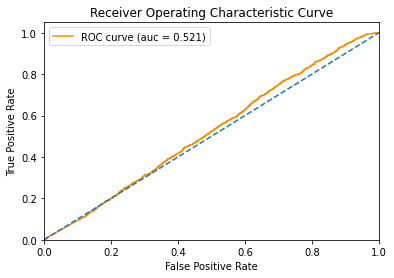

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 1.301, accuracy = 0.747
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]


<Figure size 432x288 with 0 Axes>

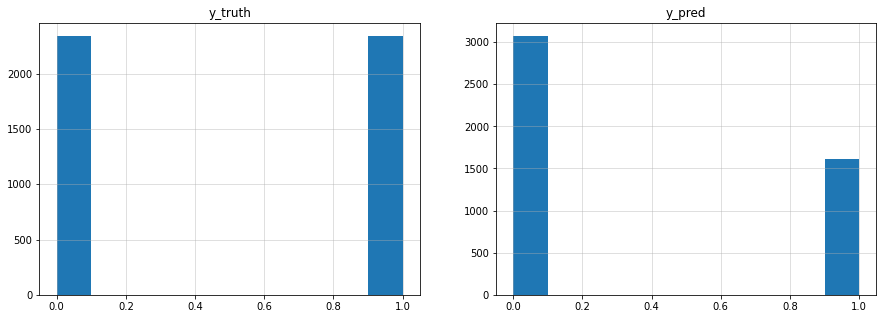

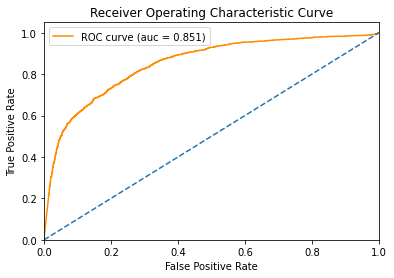

In [3]:
print('fake x, fake y')
print_pred('data/pt_simple_1gd_last/fakexy.h5')
print('fake x, real y')
print_pred('data/pt_simple_1gd_last/fakex_realy.h5')

fake x, fake y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 1.817, accuracy = 0.547
y_truth:  [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

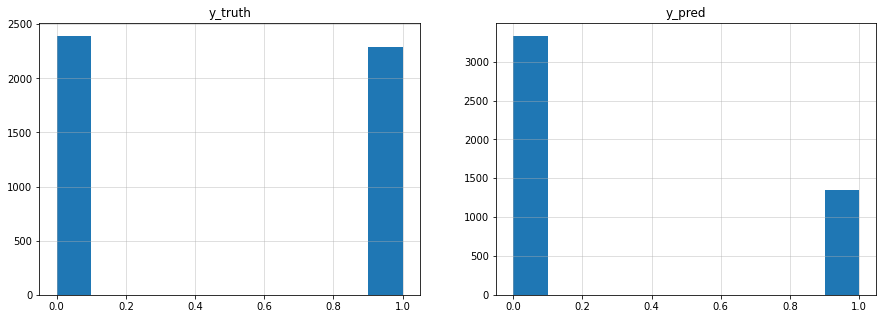

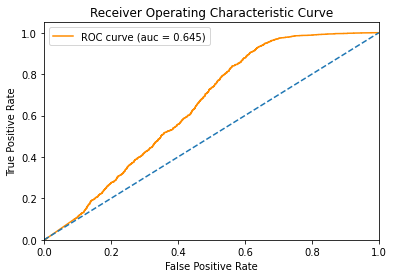

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 4.721, accuracy = 0.708
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

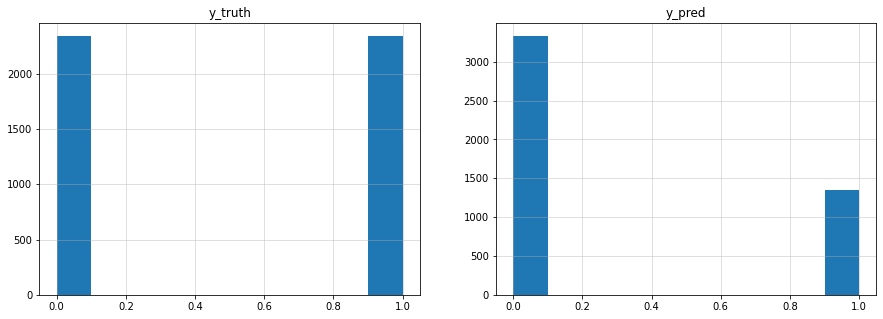

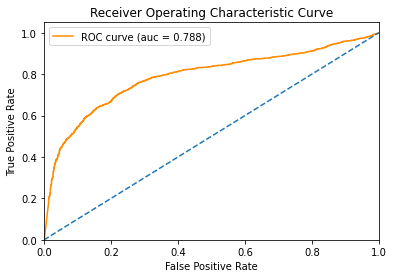

In [6]:
print('fake x, fake y')
print_pred('data/pt_simple_5gd/fakexy.h5')
print('fake x, real y')
print_pred('data/pt_simple_5gd/fakex_realy.h5')

fake x, fake y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 1.81, accuracy = 0.547
y_truth:  [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

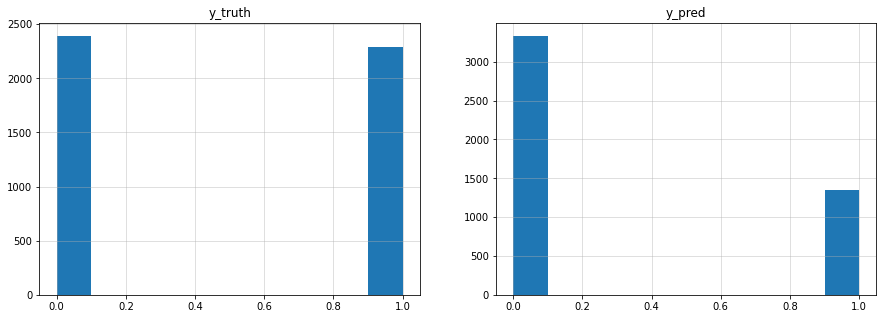

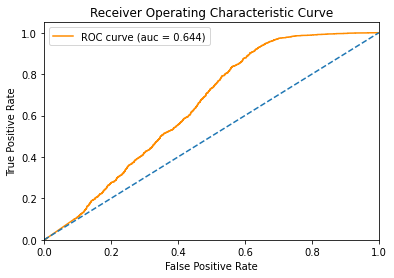

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 4.672, accuracy = 0.707
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

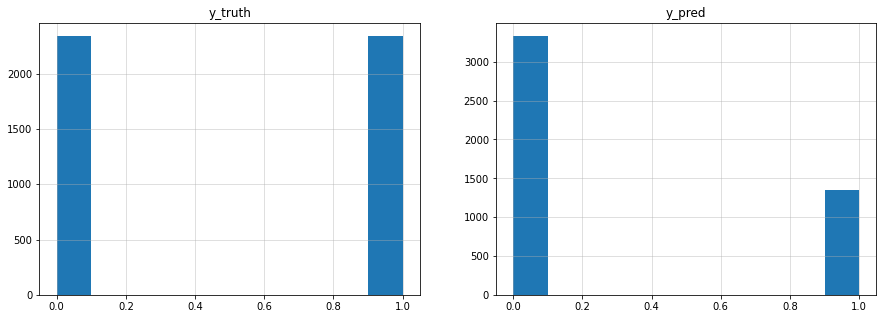

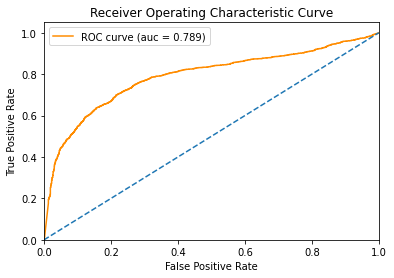

In [4]:
print('fake x, fake y')
print_pred('data/pt_simple_5gd_last/fakexy.h5')
print('fake x, real y')
print_pred('data/pt_simple_5gd_last/fakex_realy.h5')

fake x, fake y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 1.22, accuracy = 0.597
y_truth:  [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

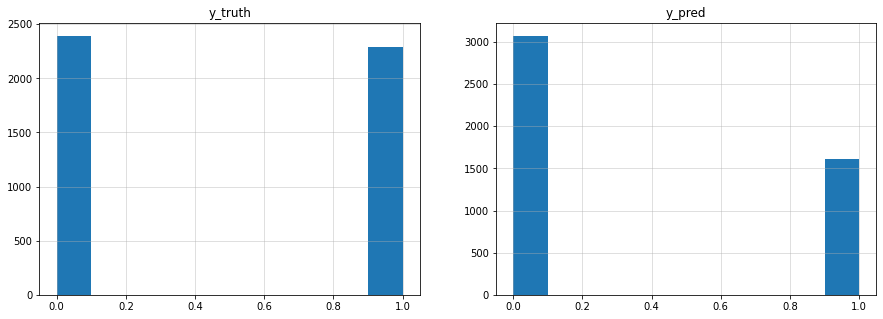

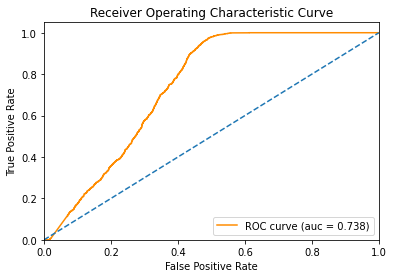

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 4.474, accuracy = 0.67
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

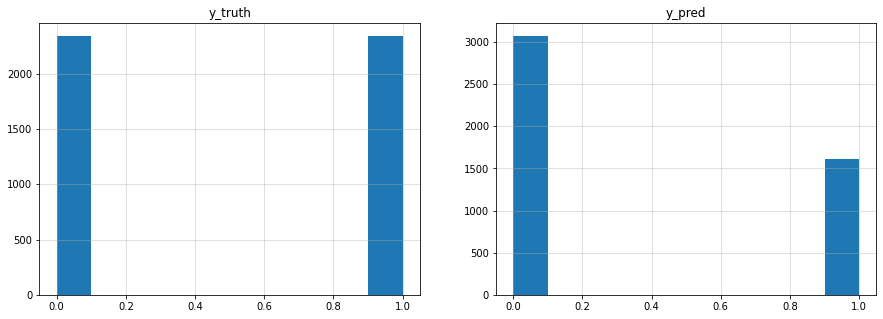

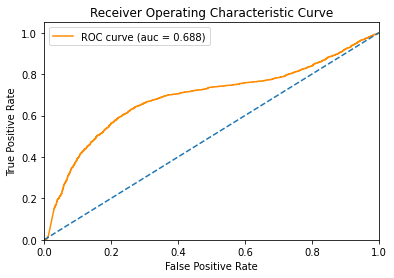

In [7]:
print('fake x, fake y')
print_pred('data/pt_complex_5gd/fakexy.h5')
print('fake x, real y')
print_pred('data/pt_complex_5gd/fakex_realy.h5')

fake x, fake y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 1.096, accuracy = 0.622
y_truth:  [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
y_pred:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

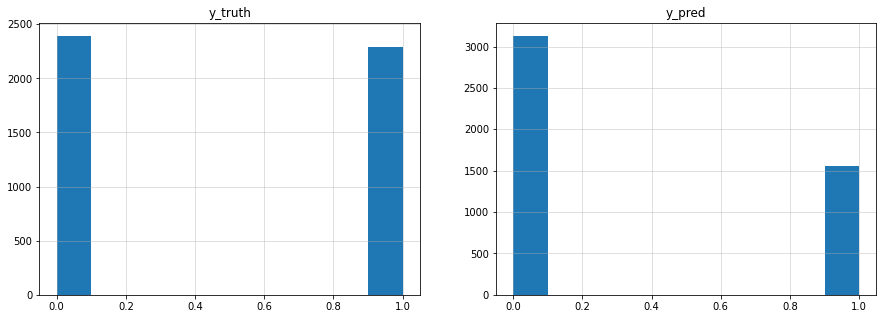

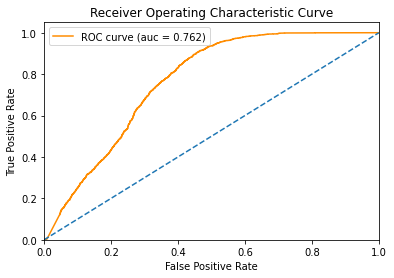

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 2.352, accuracy = 0.657
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

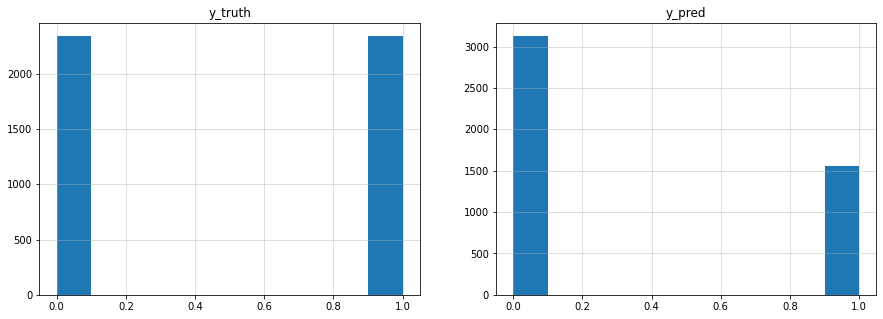

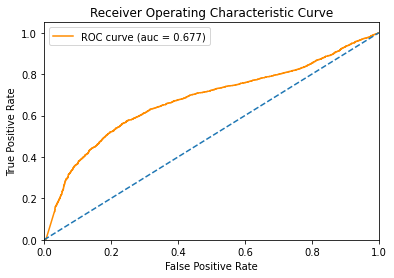

In [10]:
print('fake x, fake y')
print_pred('data/pt_complex_5gd_last/fakexy.h5')
print('fake x, real y')
print_pred('data/pt_complex_5gd_last/fakex_realy.h5')

fake x, fake y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 3.923, accuracy = 0.543
y_truth:  [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
y_pred:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

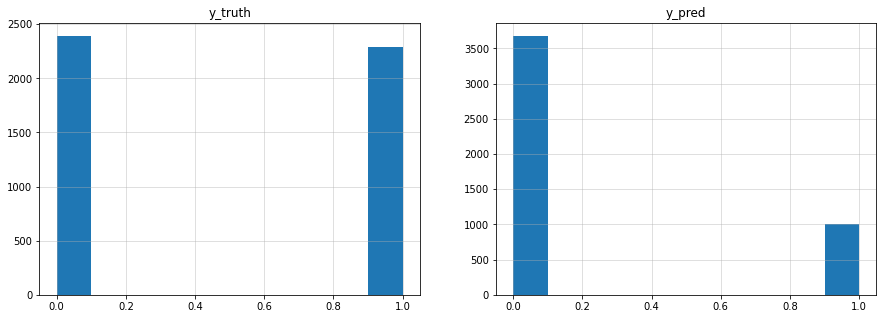

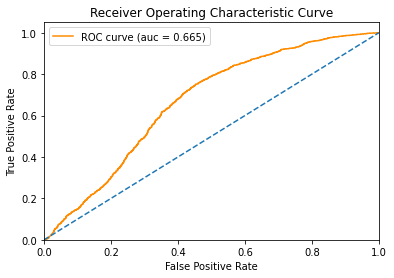

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 5.815, accuracy = 0.594
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

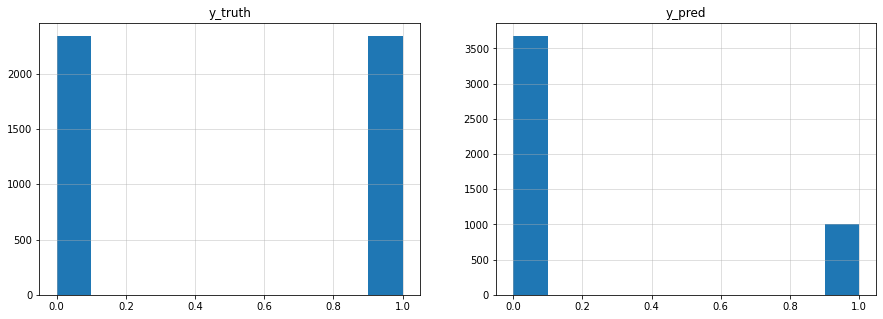

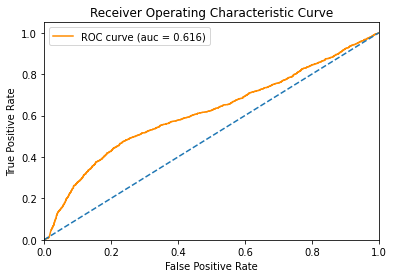

In [3]:
print('fake x, fake y')
print_pred('data/pt_complex_1gd/fakexy.h5')
print('fake x, real y')
print_pred('data/pt_complex_1gd/fakex_realy.h5')

fake x, fake y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 2.782, accuracy = 0.543
y_truth:  [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
y_pred:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

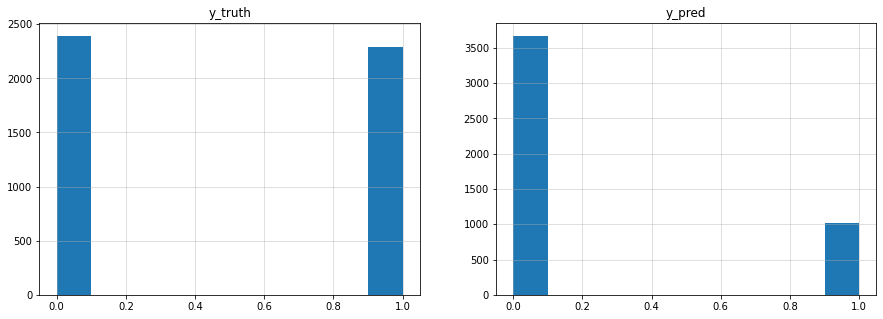

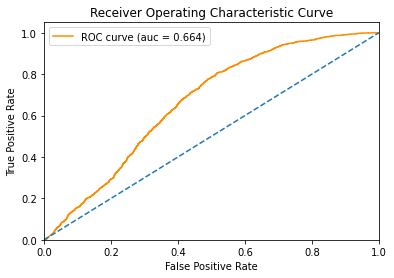

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 3.969, accuracy = 0.595
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

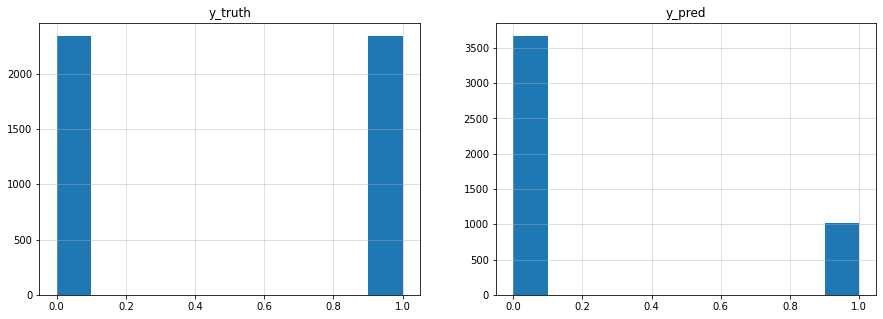

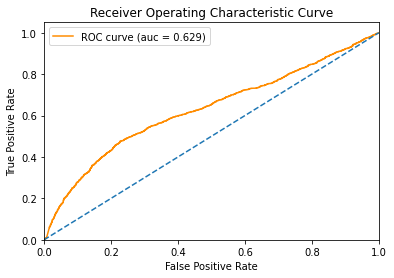

In [3]:
print('fake x, fake y')
print_pred('data/pt_complex_1gd_last/fakexy.h5')
print('fake x, real y')
print_pred('data/pt_complex_1gd_last/fakex_realy.h5')

fake x, fake y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 0.825, accuracy = 0.752
y_truth:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

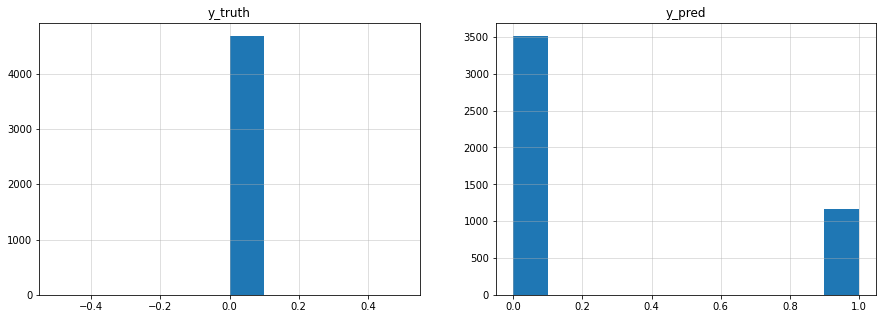

/home/cetc/vp.3.8.2/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


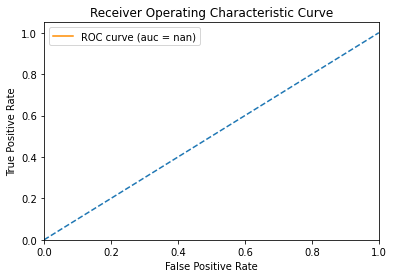

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 8.042, accuracy = 0.611
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

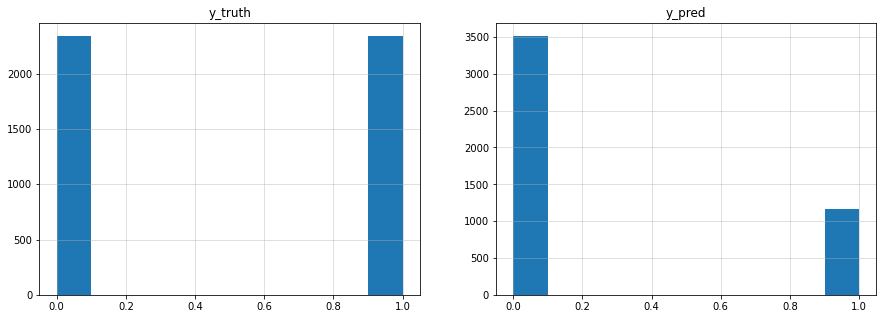

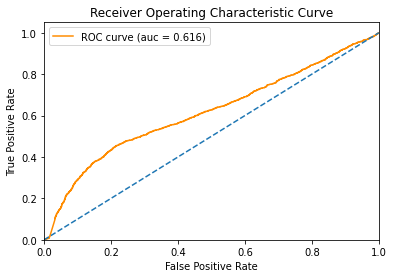

In [4]:
print('fake x, fake y')
print_pred('data/pt_complex_5gd_zeros/fakexy.h5')
print('fake x, real y')
print_pred('data/pt_complex_5gd_zeros/fakex_realy.h5')

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 5.641, accuracy = 0.58
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

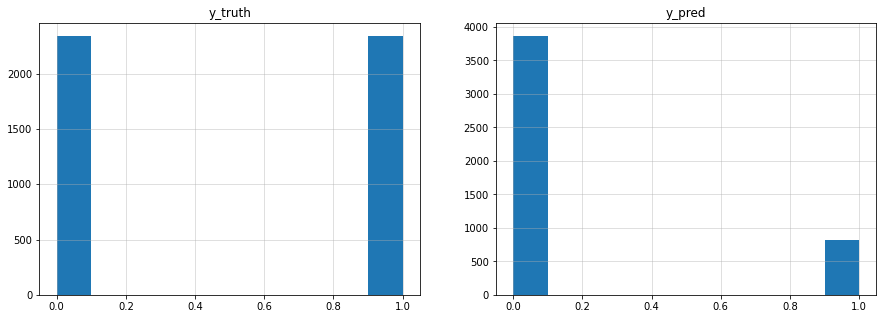

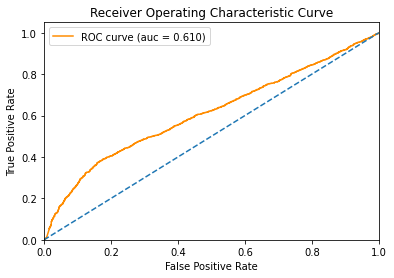

In [3]:
print('fake x, real y')
print_pred('data/pt_complex_1gd_last_zeros/fakex_realy.h5')

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 6.131, accuracy = 0.509
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


<Figure size 432x288 with 0 Axes>

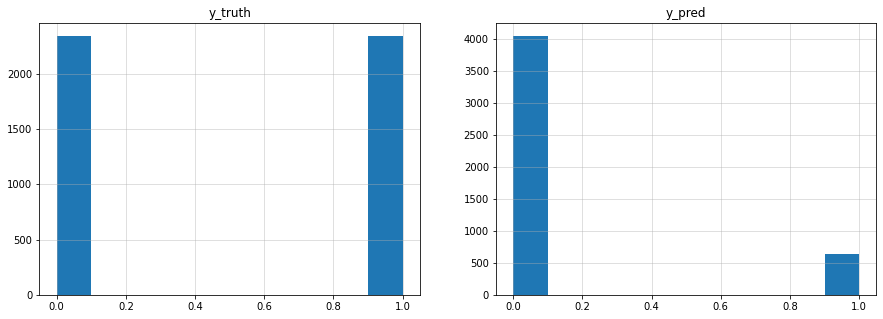

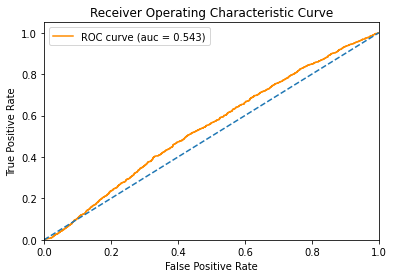

In [3]:
print('fake x, real y')
print_pred('data/pt_complex_5gd_noglossdel_last/fakex_realy.h5')

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 6.864, accuracy = 0.507
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


<Figure size 432x288 with 0 Axes>

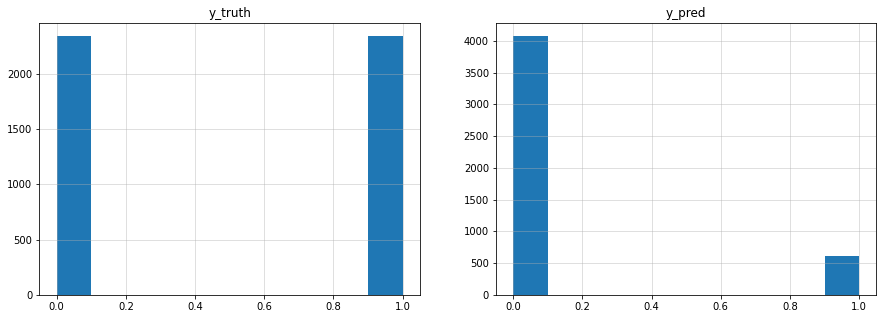

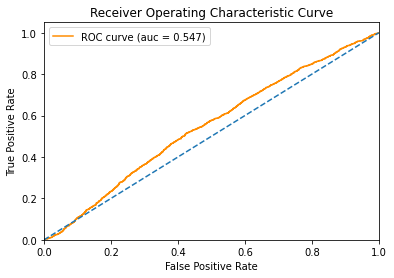

In [3]:
print('fake x, real y')
print_pred('data/pt_complex_5gd_noglossdel_best/fakex_realy.h5')

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 0.81, accuracy = 0.644
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

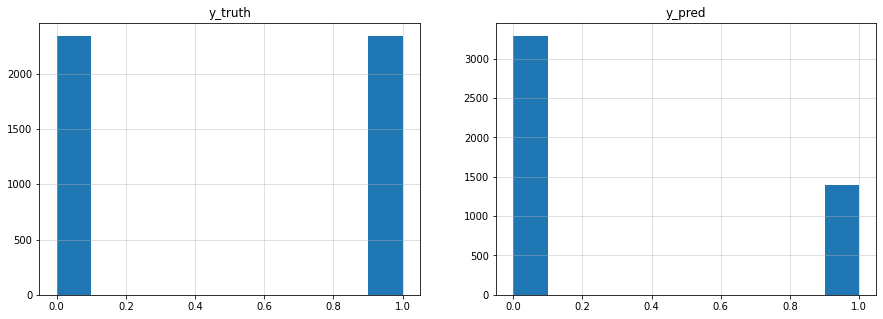

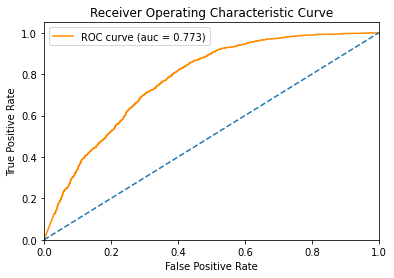

In [20]:
print('fake x, real y')
print_pred('data/pt_complex_1gd_noglossdel_last_zeros/fakex_realy.h5')

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 0.795, accuracy = 0.643
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

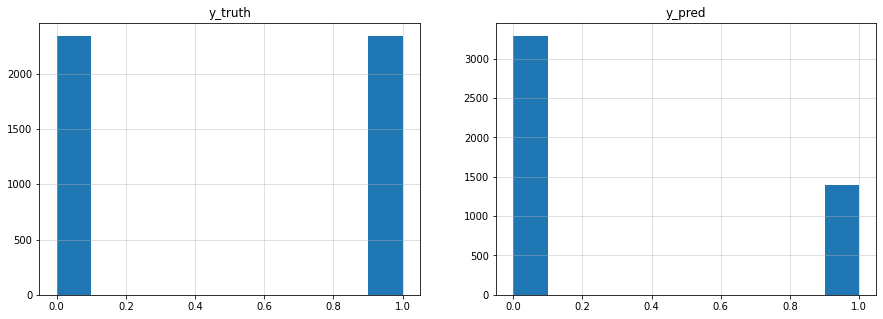

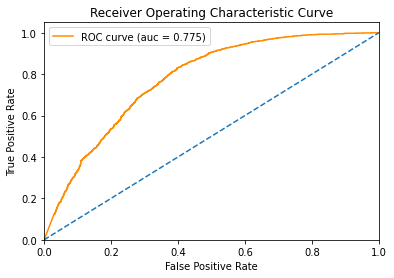

In [21]:
print('fake x, real y')
print_pred('data/pt_complex_1gd_noglossdel_last/fakex_realy.h5')

fake x, real y
We are running on CPU!
Param size = 1337.826 MB



Testing result: loss = 1.888, accuracy = 0.544
y_truth:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
y_pred:  [0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]


<Figure size 432x288 with 0 Axes>

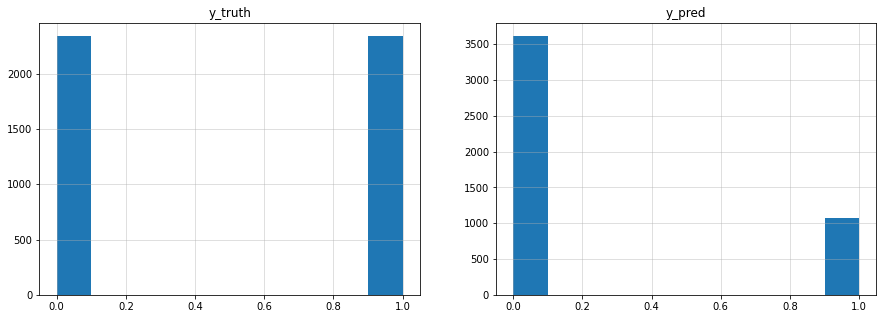

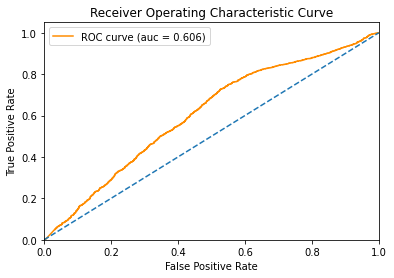

In [6]:
print('fake x, real y')
print_pred('data/pt_complex_2gd_noglossdel_best/fakex_realy.h5')